# Import Libraries and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from copy import deepcopy

from plotstyle import init_style
init_style()

from qspectro2d.config import create_base_sim_oqs
from qspectro2d.spectroscopy.one_d_field import (
    parallel_compute_1d_e_comps,
    _compute_P_phi1_phi2,
    _phase_cycle_component,
    _worker_P_phi_pair,
)
from qspectro2d.config.default_simulation_params import (
    PHASE_CYCLING_PHASES,
    COMPONENT_MAP,
    DETECTION_PHASE,
)

# Load Simulation Module

In [2]:
# Load or create simulation module
from project_config import SCRIPTS_DIR
config_path = SCRIPTS_DIR / "config.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path=config_path)

print(f"Simulation loaded with n_phases: {sim_oqs.simulation_config.n_phases}")
print(f"Signal types: {sim_oqs.simulation_config.signal_types}")
print(f"Time cut: {time_cut} fs")

🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)
Simulation loaded with n_phases: 4
Signal types: ['rephasing']
Time cut: inf fs


# Determine and Visualize Phases

Effective phases: (0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469)


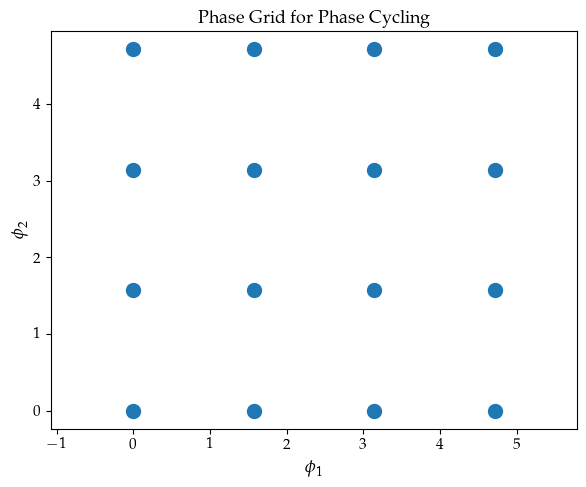

In [3]:
# Determine effective phases
n_ph = sim_oqs.simulation_config.n_phases
phases_src = PHASE_CYCLING_PHASES
phases_eff = tuple(float(x) for x in phases_src[:n_ph])

print(f"Effective phases: {phases_eff}")

# Visualize phase grid
phi1_grid, phi2_grid = np.meshgrid(phases_eff, phases_eff)
plt.figure(figsize=(6, 5))
plt.scatter(phi1_grid, phi2_grid, c='C0', s=100)
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.title('Phase Grid for Phase Cycling')
plt.axis('equal')
plt.show()

# Compute P_phi1_phi2 Grid

In [4]:
# Compute P_{phi1,phi2} grid
n_t = len(sim_oqs.times_det)
P_grid = np.zeros((len(phases_eff), len(phases_eff), n_t), dtype=np.complex128)

futures = []
with ProcessPoolExecutor() as ex:
    for phi1 in phases_eff:
        for phi2 in phases_eff:
            futures.append(ex.submit(_worker_P_phi_pair, deepcopy(sim_oqs), phi1, phi2))

temp_results = {}
for fut in as_completed(futures):
    phi1_v, phi2_v, t_det, P_phi = fut.result()
    temp_results[(phi1_v, phi2_v)] = (t_det, P_phi)

for i, phi1 in enumerate(phases_eff):
    for j, phi2 in enumerate(phases_eff):
        _, P_phi = temp_results[(phi1, phi2)]
        P_grid[i, j, :] = P_phi

print(f"P_grid shape: {P_grid.shape}")
P_grid

# TODO check if P_grid[i, j, :] == P_grid[j, i, :]:


P_grid shape: (4, 4, 301)


array([[[ 8.19563866e-08+3.35276127e-08j,
          3.35276127e-08+2.42143869e-08j,
         -2.23517418e-08-2.98023224e-08j, ...,
         -2.50525773e-07-4.80562449e-07j,
         -1.18612661e-07-5.17757144e-07j,
          1.55960151e-08-5.16942237e-07j],
        [ 8.19563866e-08+3.35276127e-08j,
          3.35276127e-08+2.42143869e-08j,
         -2.23517418e-08-2.98023224e-08j, ...,
         -2.50525773e-07-4.80562449e-07j,
         -1.18612661e-07-5.17757144e-07j,
          1.55960151e-08-5.16942237e-07j],
        [ 8.19563866e-08+3.35276127e-08j,
          3.35276127e-08+2.42143869e-08j,
         -2.23517418e-08-2.98023224e-08j, ...,
         -2.50525773e-07-4.80562449e-07j,
         -1.18612661e-07-5.17757144e-07j,
          1.55960151e-08-5.16942237e-07j],
        [ 8.19563866e-08+3.35276127e-08j,
          3.35276127e-08+2.42143869e-08j,
         -2.23517418e-08-2.98023224e-08j, ...,
         -2.50525773e-07-4.80562449e-07j,
         -1.18612661e-07-5.17757144e-07j,
          1

# Visualize P Grid

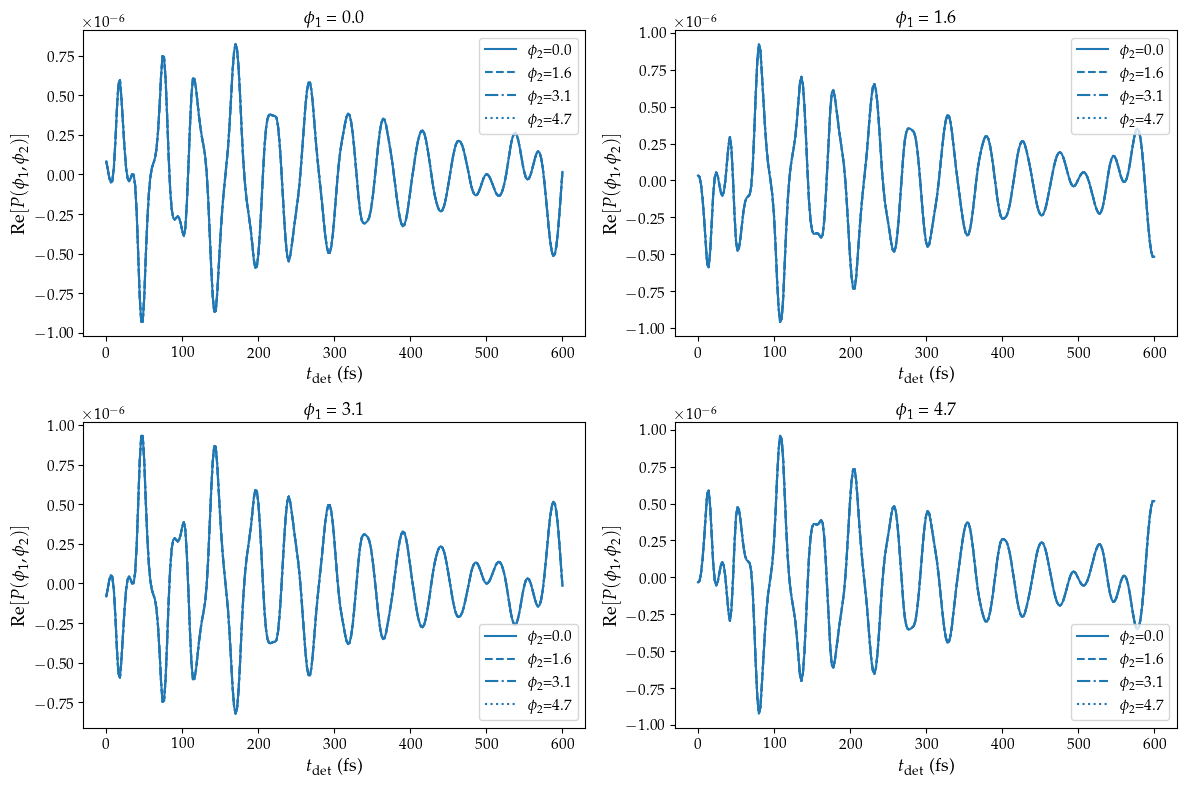

In [5]:
# Visualize P_grid slices
t_det = sim_oqs.times_det
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(min(4, len(phases_eff))):
    ax = axes.flat[i]
    for j in range(len(phases_eff)):
        ax.plot(t_det, np.real(P_grid[i, j, :]), label=f'$\phi_2$={phases_eff[j]:.1f}')
    ax.set_xlabel(r'$t_{\mathrm{det}}$ (fs)')
    ax.set_ylabel(r'$\mathrm{Re}[P(\phi_1, \phi_2)]$')
    ax.set_title(f'$\phi_1$ = {phases_eff[i]:.1f}')
    ax.legend()
plt.tight_layout()
plt.show()

# Extract Components

In [6]:
# Extract components
sig_types = sim_oqs.simulation_config.signal_types
phi_det_val = float(DETECTION_PHASE)
P_comps = {}
for sig in sig_types:
    lmn_tuple = COMPONENT_MAP[sig]
    P_comp = _phase_cycle_component(
        phases_eff,
        phases_eff,
        P_grid,
        lmn=lmn_tuple,
        phi_det=phi_det_val,
        normalize=True,
    )
    P_comps[sig] = P_comp
    print(f"Extracted {sig} component, max abs: {np.max(np.abs(P_comp)):.2e}")

Extracted rephasing component, max abs: 5.62e-23
Extracted rephasing component, max abs: 5.62e-23


# Visualize Extracted Components

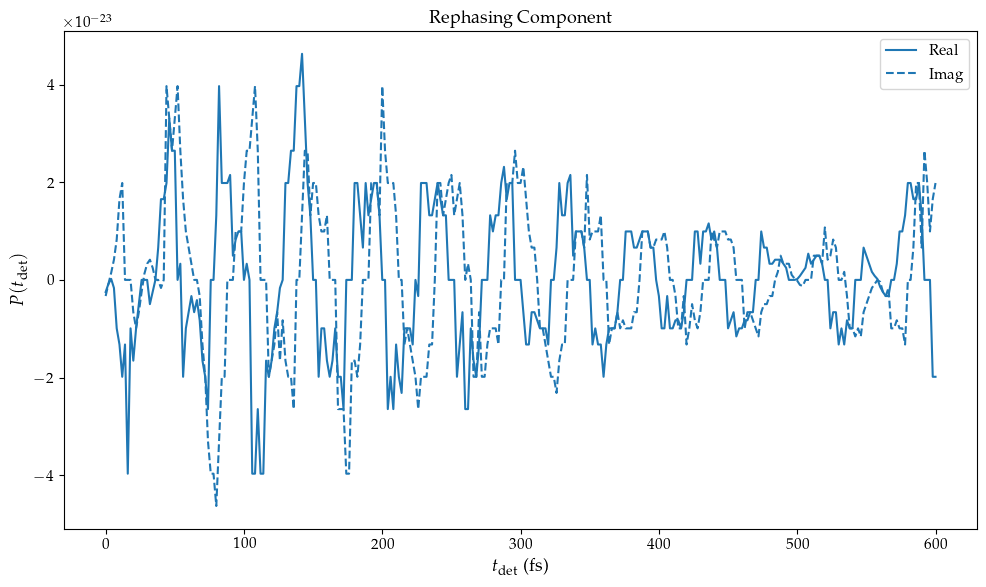

In [7]:
# Visualize extracted components
fig, axes = plt.subplots(len(sig_types), 1, figsize=(10, 6))
if len(sig_types) == 1:
    axes = [axes]
for ax, sig in zip(axes, sig_types):
    P_comp = P_comps[sig]
    ax.plot(t_det, np.real(P_comp), 'C0-', label='Real')
    ax.plot(t_det, np.imag(P_comp), 'C1--', label='Imag')
    ax.set_xlabel(r'$t_{\mathrm{det}}$ (fs)')
    ax.set_ylabel(r'$P(t_{\mathrm{det}})$')
    ax.set_title(f'{sig.capitalize()} Component')
    ax.legend()
plt.tight_layout()
plt.show()

# Apply Time Cut Mask

In [8]:
# Apply time cut mask and compute E
E_list = []
for sig in sig_types:
    P_comp = P_comps[sig]
    E_comp = 1j * P_comp
    if time_cut is not None and np.isfinite(time_cut):
        t_mask = (sim_oqs.times_det_actual <= float(time_cut)).astype(np.float64)
        E_comp = E_comp * t_mask
    E_list.append(E_comp)
    print(f"E_{sig} computed, masked if time_cut applied")

E_rephasing computed, masked if time_cut applied


# Visualize Final E Components

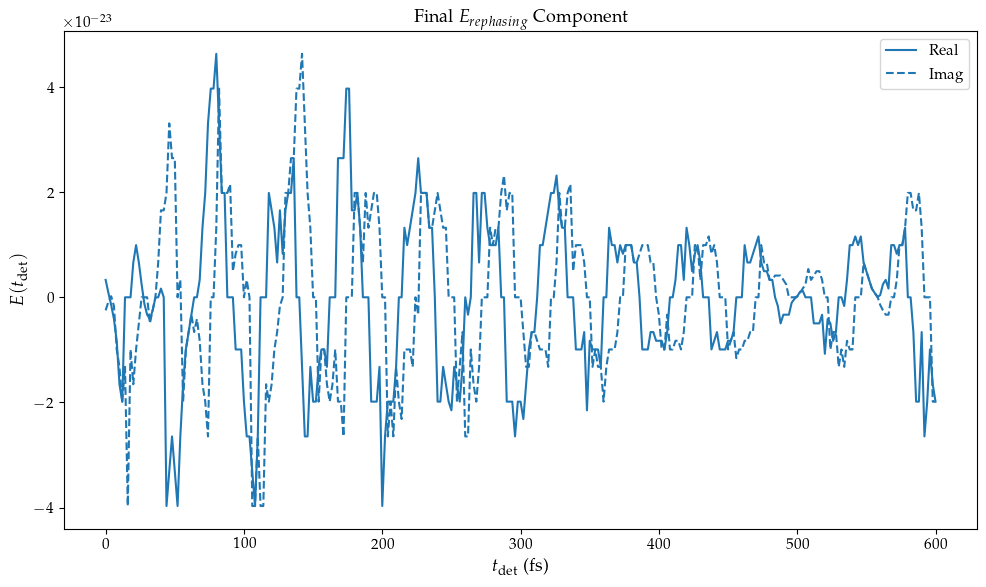

In [9]:
# Visualize final E components
fig, axes = plt.subplots(len(E_list), 1, figsize=(10, 6))
if len(E_list) == 1:
    axes = [axes]
for ax, (sig, E_comp) in zip(axes, zip(sig_types, E_list)):
    ax.plot(t_det, np.real(E_comp), 'C0-', label='Real')
    ax.plot(t_det, np.imag(E_comp), 'C1--', label='Imag')
    ax.set_xlabel(r'$t_{\mathrm{det}}$ (fs)')
    ax.set_ylabel(r'$E(t_{\mathrm{det}})$')
    ax.set_title(f'Final $E_{{{sig}}}$ Component')
    ax.legend()
plt.tight_layout()
plt.show()